In [1]:
### do our imports
import os,sys
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
import nibabel as nib
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
%matplotlib inline

In [2]:
#### define nifti volume data loader class
class NiftisLoader(Dataset):
    """Load a list of registered T1 and T2 volumes"""
    def __init__(self,nifti1,nifti2,transform=None):
        """
        Args:
            nifti1: list of nifti images for first modality
            nifti2: list of nifti images for second modality
            transform: Optional transform to be applied to sample
        """
        ### define the variables from the input here
        self.nifti1=[line.strip() for line in open(nifti1, 'r')]
        self.nifti2=[line.strip() for line in open(nifti2, 'r')]
        self.transform=transform

    def __len__(self):
        return len(self.nifti2)
    
    ### 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #### load the niftis
        img1=nib.load(self.nifti1[idx]).get_data().astype(float)
        img2=nib.load(self.nifti2[idx]).get_data().astype(float)

        sample = {'nii1': img1, 'nii2': img2}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
        


In [3]:
nifti_dataset = NiftisLoader(nifti1='T1s.txt',nifti2='T2s.txt')
nifti_dataset[1]['nii1'].shape

CPU times: user 824 ms, sys: 481 ms, total: 1.31 s
Wall time: 2.63 s


In [4]:
%%time
############# prep list of slices as alternate input into dataloader

def prep_data_slices(nifti1,nifti2,slices):
        
        nifti1=[line.strip() for line in open(nifti1, 'r')]
        nifti2=[line.strip() for line in open(nifti2, 'r')]
        img_s1=[]
        img_s2=[]
        ### loop over input file to create list   
        for i in range(0,len(nifti2)):
            img1=nib.load(nifti1[i]).get_data().astype(float)
            img2=nib.load(nifti2[i]).get_data().astype(float)
        #### get dimension limit:
            dim_lim=min(img1.shape)
            if slices >= dim_lim:
                slices=dim_lim-30
            slidx=random.sample(range(dim_lim),slices)
            slimg1=[]
            slimg2=[]
            for j in range(len(slidx)):
                slimg1.append(img1[slidx[j],:,:])
                slimg1.append(img1[:,slidx[j],:])
                slimg1.append(img1[:,:,slidx[j]])
                slimg2.append(img2[slidx[j],:,:])
                slimg2.append(img2[:,slidx[j],:])
                slimg2.append(img2[:,:,slidx[j]])
            img_s1.append(slimg1)
            img_s2.append(slimg2)
        T1_slc = [img for arr in img_s1 for img in arr]
        T2_slc = [img for arr in img_s2 for img in arr]
        return T1_slc,T2_slc

T1_slc,T2_slc= prep_data_slices('T1s.txt','T2s.txt',slices=10)
    

CPU times: user 1min 28s, sys: 44.8 s, total: 2min 13s
Wall time: 3min 4s


In [5]:
###### list of 2d numpy arrays of T1 and T2. 
##### 
class SliceLoader(Dataset):
    """Load a list of registered T1 and T2 volumes"""
    def __init__(self,nifti1,nifti2,slices=None,transform=None):
        """
        Args:
            nifti1: list of numpy array T1 slices
            nifti2: list of numpy array T2 images
            transform: Optional transform to be applied to sample
        """
        ### define the variables from the input here
        self.nifti1=nifti1
        self.nifti2=nifti2
        self.transform=transform
        
    def __len__(self):
            return len(self.nifti2)
    
    ###
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #### load the niftis
        img1=self.nifti1[idx]
        img2=self.nifti2[idx]
        
        #### normalize niftis between 0 and 1
        img1=img1/np.max(img1)
        img2=img2/np.max(img2)
    
        ##### no slices will load nifti volume for traning
        
        sample = {'nii1': img1, 'nii2': img2}
        return sample
        



In [6]:
%%time
slice_dataset = SliceLoader(nifti1=T1_slc,nifti2=T2_slc)
T1_slc=[],T2_slc=[] #clear memory

CPU times: user 15 µs, sys: 2 µs, total: 17 µs
Wall time: 37.2 µs


In [7]:
len(slice_dataset)

3300

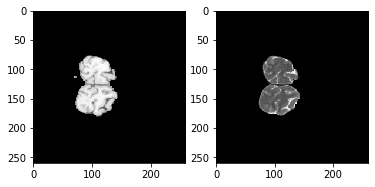

In [8]:
plt.subplot(1,2,1)
plt.imshow(slice_dataset[2500]['nii1'],cmap='Greys_r')
plt.subplot(1,2,2)
plt.imshow(slice_dataset[2500]['nii2'],cmap='Greys_r')

In [ ]:
plt.subplot(1,2,1)
plt.imshow(slice_dataset[1]['nii1'][20].transpose())
plt.subplot(1,2,2)
plt.imshow(slice_dataset[1]['nii2'][20].transpose())